# 02 - Baseline Model: ElasticNet Logistic Regression

## Objective
Train and evaluate the primary ElasticNet Logistic Regression model for PAM50 subtype classification.

## Why ElasticNet?
- **L1 (Lasso)**: Automatic feature selection, sparse solutions
- **L2 (Ridge)**: Handles multicollinearity, stabilizes coefficients
- **ElasticNet**: Best of both - selects important genes while handling correlated features
- **Interpretable**: Coefficients directly indicate gene importance per class

## Pipeline
Log2Transform -> VarianceFilter -> StandardScaler -> SelectKBest -> ElasticNet LR

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import random
import warnings
import pickle

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_predict, cross_validate,
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report,
)

In [15]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"

for d in [FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

EXPRESSION_FILE = "HiSeqV2.csv"
PAM50_LABELS_FILE = "brca_pam50.csv.csv"

RANDOM_SEED = 42
CV_FOLDS = 5
VARIANCE_THRESHOLD = 0.01
LOG_TRANSFORM_THRESHOLD = 100
DEFAULT_FEATURE_K = 200
PRIMARY_METRIC = "f1_macro"

SAMPLE_ID_CANDIDATES = ["sample", "sample_id", "patient_id", "barcode", "Sample", "SAMPLE_ID"]
PAM50_LABEL_CANDIDATES = ["PAM50", "pam50", "Subtype", "subtype", "label", "Label"]
EXCLUDED_LABELS = ["Unknown", "unknown", "NA", "N/A", "", None]

PAM50_SUBTYPES = ["LumA", "LumB", "Her2", "Basal", "Normal"]
PAM50_COLORS = {
    "LumA": "#3498db", "LumB": "#2ecc71", "Her2": "#e74c3c",
    "Basal": "#9b59b6", "Normal": "#f39c12",
}

ELASTICNET_PARAMS = {
    "C": list(np.logspace(-3, 2, 10)),
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}
ELASTICNET_DEFAULTS = {
    "solver": "saga", "penalty": "elasticnet",
    "class_weight": "balanced", "max_iter": 5000,
    "random_state": RANDOM_SEED, "n_jobs": -1,
}

SKIP_TUNING = True  

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.rcParams.update({
    "figure.dpi": 100, "savefig.dpi": 150, "font.size": 10,
    "axes.labelsize": 11, "axes.titlesize": 12, "legend.fontsize": 9,
    "figure.figsize": (8, 6), "axes.spines.top": False, "axes.spines.right": False,
})

In [16]:
class Log2Transformer(BaseEstimator, TransformerMixin):
    """Apply log2(x+1) if data max > threshold (i.e. raw counts)."""
    def __init__(self, threshold=100.0, force=False):
        self.threshold = threshold
        self.force = force
        self.applied_ = False

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.applied_ = self.force or (np.nanmax(X) > self.threshold)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        if self.applied_:
            X = np.clip(X, 0, None)
            X = np.log2(X + 1)
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

In [17]:
def normalize_sample_id(sample_id):
    sample_id = str(sample_id).strip()
    if sample_id.startswith("TCGA-") and len(sample_id) >= 15:
        return sample_id[:15]
    return sample_id


def load_expression_data(filepath):
    print(f"Loading expression data from {filepath}...")
    df = pd.read_csv(filepath, index_col=0)
    print(f"  Raw shape: {df.shape}")
    first_col_tcga = any(str(c).startswith("TCGA-") for c in df.columns[:10])
    first_row_tcga = any(str(c).startswith("TCGA-") for c in df.index[:10])
    if first_col_tcga and not first_row_tcga:
        print("  Detected: genes as rows -> transposing")
        df = df.T
    elif not (first_row_tcga and not first_col_tcga) and df.shape[0] > df.shape[1]:
        print("  Inferred: genes as rows -> transposing")
        df = df.T
    df.index = [normalize_sample_id(s) for s in df.index]
    df.index.name = "sample_id"
    df = df.apply(pd.to_numeric, errors="coerce")
    print(f"  Final shape: {df.shape} (samples x genes)")
    return df


def load_pam50_labels(filepath):
    print(f"Loading PAM50 labels from {filepath}...")
    df = pd.read_csv(filepath)
    print(f"  Raw shape: {df.shape}")
    sample_col = next((c for c in SAMPLE_ID_CANDIDATES if c in df.columns), df.columns[0])
    label_col = next((c for c in PAM50_LABEL_CANDIDATES if c in df.columns), df.columns[1])
    labels_df = df[[sample_col, label_col]].copy()
    labels_df.columns = ["sample_id", "PAM50"]
    labels_df["sample_id"] = labels_df["sample_id"].apply(normalize_sample_id)
    labels_df = labels_df.drop_duplicates(subset="sample_id", keep="first")
    labels_df = labels_df[~labels_df["PAM50"].isin(EXCLUDED_LABELS)]
    print(f"  Final: {len(labels_df)} labeled samples")
    return labels_df


def load_data():
    expression_df = load_expression_data(DATA_DIR / EXPRESSION_FILE)
    labels_df = load_pam50_labels(DATA_DIR / PAM50_LABELS_FILE)
    overlap = set(expression_df.index) & set(labels_df["sample_id"])
    labels_df = labels_df[labels_df["sample_id"].isin(overlap)]
    X = expression_df.loc[labels_df["sample_id"].values]
    y = pd.Series(labels_df["PAM50"].values, index=X.index, name="PAM50")
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    labeled_ids = set(labels_df["sample_id"])
    X_unlabeled = expression_df[~expression_df.index.isin(labeled_ids)]
    print(f"  Labeled: {X.shape[0]}, Unlabeled: {X_unlabeled.shape[0]}")
    return X, y, X_unlabeled

In [18]:
def _safe_cv_folds(y, cv_folds):
    class_counts = pd.Series(y).value_counts()
    min_count = class_counts.min()
    if min_count < cv_folds:
        safe = max(2, min_count)
        print(f"  WARNING: Class '{class_counts.idxmin()}' has {min_count} sample(s). "
              f"CV folds: {cv_folds} -> {safe}.")
        return safe
    return cv_folds


def create_elasticnet_pipeline(n_features=DEFAULT_FEATURE_K, C=1.0, l1_ratio=0.5):
    return Pipeline([
        ("log_transform", Log2Transformer(threshold=LOG_TRANSFORM_THRESHOLD)),
        ("variance_filter", VarianceThreshold(threshold=VARIANCE_THRESHOLD)),
        ("scaler", StandardScaler()),
        ("feature_selector", SelectKBest(score_func=f_classif, k=n_features)),
        ("classifier", LogisticRegression(C=C, l1_ratio=l1_ratio, **ELASTICNET_DEFAULTS)),
    ])


def tune_model(X, y):
    print("\nTuning ELASTICNET model...")
    pipeline = create_elasticnet_pipeline()
    param_grid = {
        "feature_selector__k": [100, 200, 500],
        "classifier__C": ELASTICNET_PARAMS["C"],
        "classifier__l1_ratio": ELASTICNET_PARAMS["l1_ratio"],
    }
    max_k = len(y) - 1
    param_grid["feature_selector__k"] = [k for k in param_grid["feature_selector__k"] if k <= max_k]
    if not param_grid["feature_selector__k"]:
        param_grid["feature_selector__k"] = [min(100, max_k)]

    cv_folds = _safe_cv_folds(y, CV_FOLDS)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=PRIMARY_METRIC,
                        n_jobs=-1, verbose=1, refit=True, return_train_score=True)
    grid.fit(X, y)
    print(f"  Best {PRIMARY_METRIC}: {grid.best_score_:.4f}")
    print(f"  Best params: {grid.best_params_}")
    return grid.best_estimator_, grid.best_params_, pd.DataFrame(grid.cv_results_)


def evaluate_model_cv(pipeline, X, y):
    cv_folds = _safe_cv_folds(y, CV_FOLDS)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
    scoring = {"f1_macro": "f1_macro", "f1_weighted": "f1_weighted", "accuracy": "accuracy"}
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring,
                                 n_jobs=-1, return_train_score=True)
    scores = {}
    for metric in scoring:
        scores[metric] = {
            "test_mean": cv_results[f"test_{metric}"].mean(),
            "test_std": cv_results[f"test_{metric}"].std(),
            "train_mean": cv_results[f"train_{metric}"].mean(),
            "train_std": cv_results[f"train_{metric}"].std(),
        }
    return y_pred, scores


def permutation_sanity_check(pipeline, X, y):
    min_count = pd.Series(y).value_counts().min()
    safe_folds = min(CV_FOLDS, max(2, min_count))
    cv = StratifiedKFold(n_splits=safe_folds, shuffle=True, random_state=RANDOM_SEED)
    rng = np.random.RandomState(RANDOM_SEED + 999)
    y_shuffled = rng.permutation(y)
    scores = cross_validate(clone(pipeline), X, y_shuffled, cv=cv,
                            scoring="f1_macro", n_jobs=-1, return_train_score=False)
    return float(scores["test_score"].mean())

## 1. Load Data

In [19]:
X_all, y_all, X_unlabeled = load_data()

normal_mask = y_all != "Normal"
X = X_all[normal_mask].reset_index(drop=True)
y = y_all[normal_mask].reset_index(drop=True)

CLASSES_USED = sorted(y.unique().tolist())
feature_names = list(X.columns)

print(f"\nAfter Normal exclusion: {X.shape[0]} samples, {len(CLASSES_USED)} classes")
print(f"Classes: {CLASSES_USED}")
print(f"Distribution: {y.value_counts().to_dict()}")

Loading expression data from c:\Users\noyab\Downloads\medicalproject\data\HiSeqV2.csv...
  Raw shape: (20530, 1218)
  Detected: genes as rows -> transposing
  Final shape: (1218, 20530) (samples x genes)
Loading PAM50 labels from c:\Users\noyab\Downloads\medicalproject\data\brca_pam50.csv.csv...
  Raw shape: (141, 2)
  Final: 70 labeled samples
  Labeled: 70, Unlabeled: 1148

After Normal exclusion: 69 samples, 4 classes
Classes: ['Basal', 'Her2', 'LumA', 'LumB']
Distribution: {'LumB': 25, 'LumA': 18, 'Basal': 15, 'Her2': 11}


## 2. Hyperparameter Tuning

In [20]:
if SKIP_TUNING:
    print("SKIP_TUNING=True  ->  using default hyperparameters")
    n_features = min(DEFAULT_FEATURE_K, X.shape[0] - 1)
    best_pipeline = create_elasticnet_pipeline(n_features=n_features)
    best_params = {"feature_selector__k": n_features, "classifier__C": 1.0, "classifier__l1_ratio": 0.5}
    cv_results_df = None
else:
    best_pipeline, best_params, cv_results_df = tune_model(X.values, y.values)

print(f"\nUsing params: {best_params}")

SKIP_TUNING=True  ->  using default hyperparameters

Using params: {'feature_selector__k': 68, 'classifier__C': 1.0, 'classifier__l1_ratio': 0.5}


## 3. Cross-Validated Evaluation

In [21]:
y_pred, scores = evaluate_model_cv(best_pipeline, X.values, y.values)

print("\n" + "=" * 60)
print("Evaluation Summary: ElasticNet")
print("=" * 60)
print("\nCross-Validation Scores (Test):")
for metric, vals in scores.items():
    print(f"  {metric:20s}: {vals['test_mean']:.4f} (+/- {vals['test_std']:.4f})")

print("\nPer-Class Performance (from CV predictions):")
print(classification_report(y.values, y_pred, target_names=CLASSES_USED))


Evaluation Summary: ElasticNet

Cross-Validation Scores (Test):
  f1_macro            : 0.8557 (+/- 0.0594)
  f1_weighted         : 0.8510 (+/- 0.0516)
  accuracy            : 0.8549 (+/- 0.0454)

Per-Class Performance (from CV predictions):
              precision    recall  f1-score   support

       Basal       1.00      0.93      0.97        15
        Her2       0.80      0.73      0.76        11
        LumA       0.89      0.89      0.89        18
        LumB       0.78      0.84      0.81        25

    accuracy                           0.86        69
   macro avg       0.87      0.85      0.86        69
weighted avg       0.86      0.86      0.86        69



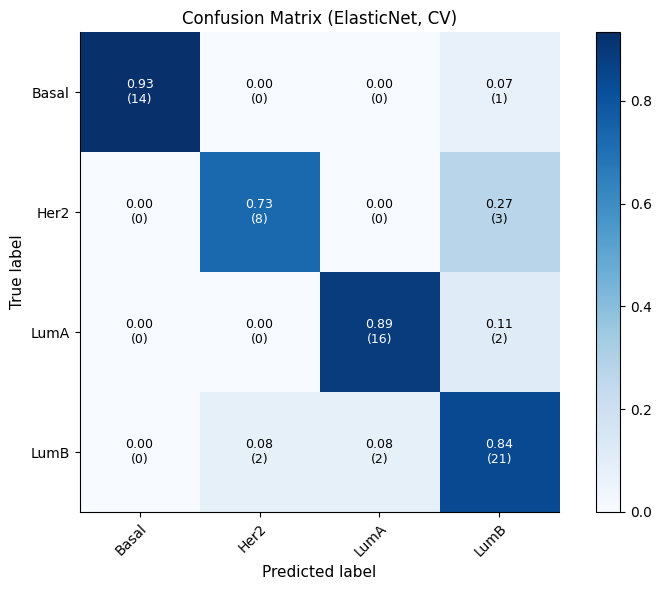

Saved confusion_matrix.png


In [22]:
# Confusion matrix
cm = confusion_matrix(y.values, y_pred, labels=CLASSES_USED)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(CLASSES_USED)), yticks=np.arange(len(CLASSES_USED)),
       xticklabels=CLASSES_USED, yticklabels=CLASSES_USED,
       title="Confusion Matrix (ElasticNet, CV)",
       ylabel="True label", xlabel="Predicted label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = cm_norm.max() / 2.0
for i in range(len(CLASSES_USED)):
    for j in range(len(CLASSES_USED)):
        ax.text(j, i, f"{cm_norm[i,j]:.2f}\n({cm[i,j]})",
                ha="center", va="center",
                color="white" if cm_norm[i,j] > thresh else "black", fontsize=9)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved confusion_matrix.png")

## 4. Permutation Sanity Check

In [23]:
print("Running permutation (shuffled-label) sanity check...")
shuffled_f1 = permutation_sanity_check(best_pipeline, X.values, y.values)
real_f1 = scores["f1_macro"]["test_mean"]

print(f"\nReal Macro-F1:     {real_f1:.4f}")
print(f"Shuffled Macro-F1: {shuffled_f1:.4f}")
print(f"Ratio:             {real_f1 / max(shuffled_f1, 1e-6):.1f}x")

if real_f1 > shuffled_f1 * 1.5:
    print("PASSED: Model learns real signal.")
else:
    print("WARNING: Model may not be learning meaningful patterns!")

overfit_gap = scores["f1_macro"]["train_mean"] - real_f1
print(f"\nOverfit gap (train - test): {overfit_gap:.4f}")

Running permutation (shuffled-label) sanity check...

Real Macro-F1:     0.8557
Shuffled Macro-F1: 0.3218
Ratio:             2.7x
PASSED: Model learns real signal.

Overfit gap (train - test): 0.1443


## 5. Train Final Model & Save

In [24]:
print("Training final model on all labeled data...")
best_pipeline.fit(X.values, y.values)
print("Done.")

# Save model pickle
pkl_path = REPORTS_DIR / "elasticnet_pipeline.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(best_pipeline, f)
print(f"Saved model to {pkl_path}")

Training final model on all labeled data...
Done.
Saved model to c:\Users\noyab\Downloads\medicalproject\reports\elasticnet_pipeline.pkl


c:\Users\noyab\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\noyab\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# model_metrics.csv
metrics_flat = {"model": "ElasticNet"}
for metric, vals in scores.items():
    metrics_flat[f"{metric}_mean"] = round(vals["test_mean"], 4)
    metrics_flat[f"{metric}_std"] = round(vals["test_std"], 4)
    metrics_flat[f"{metric}_train"] = round(vals["train_mean"], 4)
metrics_flat["shuffled_f1"] = round(shuffled_f1, 4)
metrics_flat["overfit_gap"] = round(overfit_gap, 4)

pd.DataFrame([metrics_flat]).to_csv(TABLES_DIR / "model_metrics.csv", index=False)
print("Saved model_metrics.csv")

# classification_report.csv
report_dict = classification_report(y.values, y_pred, target_names=CLASSES_USED, output_dict=True)
pd.DataFrame(report_dict).T.to_csv(TABLES_DIR / "classification_report.csv")
print("Saved classification_report.csv")

# best_hyperparameters.json
def _convert(obj):
    if isinstance(obj, (np.integer,)): return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, np.ndarray): return obj.tolist()
    return obj

with open(TABLES_DIR / "best_hyperparameters.json", "w", encoding="utf-8") as f:
    json.dump({k: _convert(v) for k, v in best_params.items()}, f, indent=2)
print("Saved best_hyperparameters.json")

Saved model_metrics.csv
Saved classification_report.csv
Saved best_hyperparameters.json


In [26]:
print("\n" + "=" * 60)
print("ELASTICNET BASELINE SUMMARY")
print("=" * 60)
print(f"\nMacro-F1: {real_f1:.4f} +/- {scores['f1_macro']['test_std']:.4f}")
print(f"Accuracy: {scores['accuracy']['test_mean']:.4f}")
print(f"Shuffled-label F1: {shuffled_f1:.4f} (anti-leakage {'PASSED' if real_f1 > shuffled_f1 * 1.5 else 'FAILED'})")
print(f"Overfit gap: {overfit_gap:.4f} (train={scores['f1_macro']['train_mean']:.4f})")
print(f"\nBest params: {best_params}")
print("\nProceed to NB03 (model comparison) or NB04 (feature insights).")


ELASTICNET BASELINE SUMMARY

Macro-F1: 0.8557 +/- 0.0594
Accuracy: 0.8549
Shuffled-label F1: 0.3218 (anti-leakage PASSED)
Overfit gap: 0.1443 (train=1.0000)

Best params: {'feature_selector__k': 68, 'classifier__C': 1.0, 'classifier__l1_ratio': 0.5}

Proceed to NB03 (model comparison) or NB04 (feature insights).
